In [80]:
from rdkit.Chem import AllChem as Chem
import pandas as pd
from rdkit import DataStructs
from rdkit.SimDivFilters import MaxMinPicker
from rdkit.Chem import Draw

In [3]:
mtor = pd.read_csv("../../data/chembl_mtor_ic50.csv", delimiter=";")
mtor = mtor[["Molecule ChEMBL ID", "Smiles"]]
mtor["mol"] = mtor.apply(lambda row: Chem.MolFromSmiles(row["Smiles"]), axis=1)
mtor["Source"] = "mtor"
mtor.rename({"Molecule ChEMBL ID":"ID"}, axis=1, inplace=True)

drugbank_mols =  Chem.SDMolSupplier('../../data/drugbank.sdf')
drugbank = [mol for mol in drugbank_mols if mol]
pd_drugbank = pd.DataFrame(drugbank, columns=["mol"])
pd_drugbank["Smiles"] = pd_drugbank.apply(lambda row: Chem.MolToSmiles(row["mol"]), axis=1)
pd_drugbank["Source"] = "drugbank"
pd_drugbank["ID"] = pd_drugbank.apply(lambda row: row["mol"].GetProp("DATABASE_ID"), axis=1)

df = pd.concat([mtor, pd_drugbank]).reset_index(drop=True)
df

[12:16:04] Explicit valence for atom # 7 N, 4, is greater than permitted
[12:16:04] ERROR: Could not sanitize molecule ending on line 20009
[12:16:04] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
[12:16:05] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:16:05] ERROR: Could not sanitize molecule ending on line 250947
[12:16:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
[12:16:05] Explicit valence for atom # 17 O, 3, is greater than permitted
[12:16:05] ERROR: Could not sanitize molecule ending on line 258130
[12:16:05] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
[12:16:05] Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:16:05] ERROR: Could not sanitize molecule ending on line 261581
[12:16:05] ERROR: Can't kekulize mol.  Unkekulized atoms: 57 58 59 60 61 62 63 64 65
[12:16:05] Explicit valence for atom # 47 Mg, 4, is greater than permitted
[12:16:05] ERROR: Could not sanitize

In [26]:
mol = df["mol"][1024]
fp = Chem.GetMorganFingerprintAsBitVect(mol, 2, 1024)
fp

In [15]:
df["fp"] = df.apply(lambda row: Chem.GetMorganFingerprintAsBitVect(row["mol"], 2, 1024), axis=1)

In [30]:
fp.ToBitString()

'000010000000000000000000000000000100000000000000000000001000001000000000000000001000000000000000000000100010000000000000000000001010000000000000000101000000000000000000000000000000000000000100000000000000000000000100000000000000000000000000000001000000000000000000000000000000000000000000000000100000010000000000000010000000000000000000000000000000000000001000000000000000000000100000000100000010000000000001000000000000000000001010010000000000001000000000100000000000000000000000000000000100000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000010110000000000001000000000000000000000001000000000000000000100001000001000000000000000000000000101000000000000000000100000000000010000000000000000000000000000000000010000000000100000000000000000000100000000000000000000000000000000000000010100000000000000000000000100000000000000000001000000010000000000000000000000001000100001000000000000000000000000000000000010000000000000000000000000000

In [42]:
DataStructs.TanimotoSimilarity(fp, fp)

1.0

In [45]:
sim = df.apply(lambda row: DataStructs.TanimotoSimilarity(row["fp"], fp), axis=1)
sim = [(i, s) for i, s in enumerate(sim) if s > 0.7]
sim

[(1024, 1.0),
 (2617, 0.8333333333333334),
 (3064, 0.7868852459016393),
 (3513, 0.7301587301587301)]

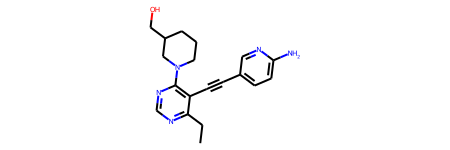

In [53]:
df["mol"][sim[3][0]]

In [59]:
mtor["fp"] = mtor.apply(lambda row: Chem.GetMorganFingerprintAsBitVect(row["mol"], 2, 1024), axis=1)
pd_drugbank["fp"] = pd_drugbank.apply(lambda row: Chem.GetMorganFingerprintAsBitVect(row["mol"], 2, 1024), axis=1)

In [60]:
sim = []
for m_i, m_mol in enumerate(mtor["fp"]):
    s = []
    for db_i, db_mol in enumerate(pd_drugbank["fp"]):
        t = DataStructs.TanimotoSimilarity(m_mol, db_mol)
        if t > 0.5:
            s.append((db_i, t))
    sim.append((m_i, s))

In [65]:
sim = [s for s in sim if len(s[1]) > 0]

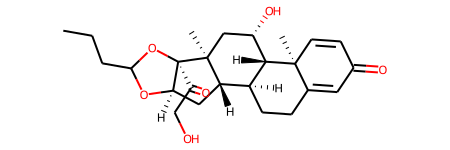

In [73]:
sim = sorted(sim, key=lambda x: len(x[1]), reverse=True)
mtor["mol"][sim[0][0]]

In [78]:
def distance_function(index1, index2):
    return 1 - DataStructs.TanimotoSimilarity(pd_drugbank["fp"][index1], pd_drugbank["fp"][index2])

picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(mtor), 50))
picked

[1204,
 318,
 441,
 477,
 645,
 850,
 1198,
 1199,
 1202,
 1378,
 1379,
 1714,
 2151,
 2609,
 2694,
 2770,
 3947,
 3860,
 985,
 322,
 1188,
 2365,
 2734,
 1935,
 1756,
 3752,
 3402,
 2885,
 2767,
 3731,
 2044,
 3779,
 4062,
 2783,
 1487,
 1859,
 2120,
 4573,
 2021,
 401,
 4176,
 872,
 658,
 3723,
 1880]

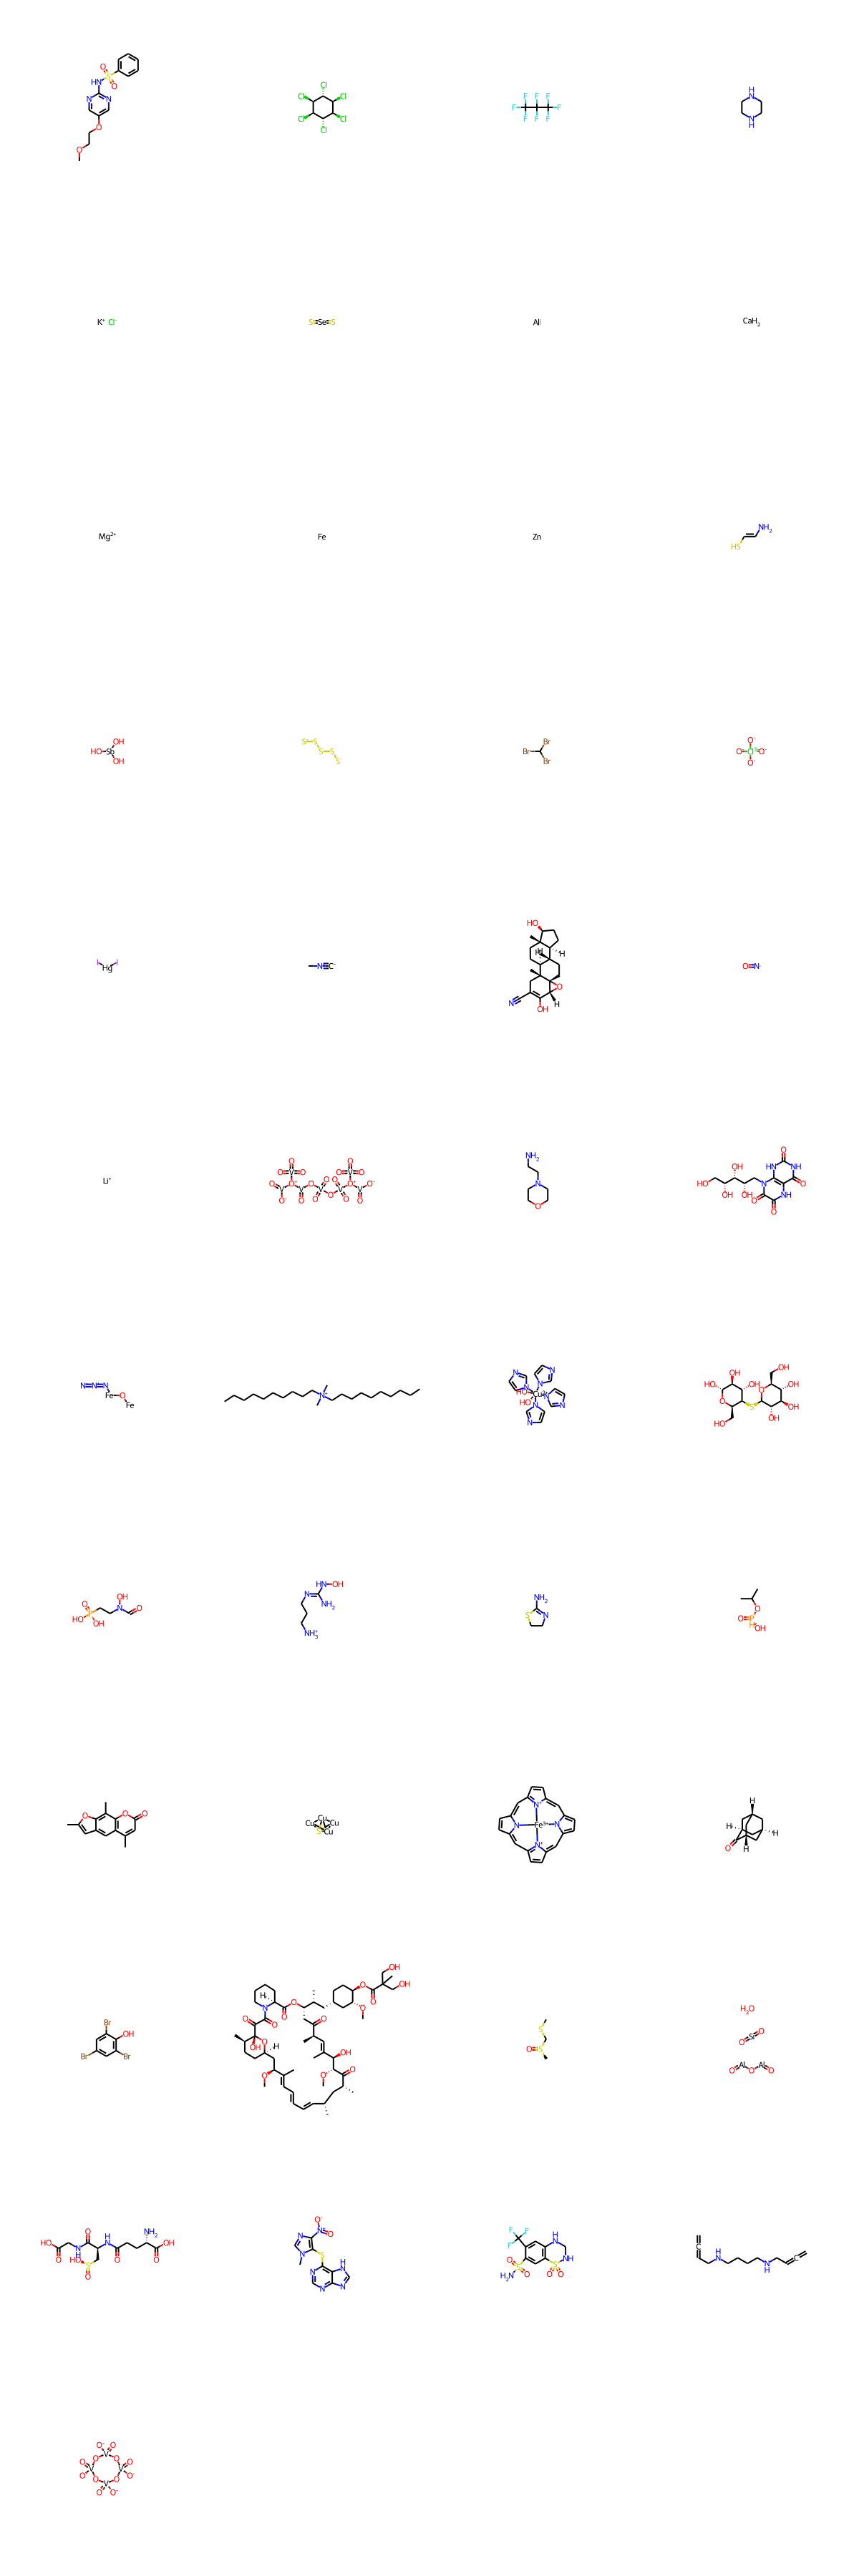

In [82]:
Draw.MolsToGridImage([pd_drugbank["mol"][mol] for mol in picked], subImgSize=(300, 300), molsPerRow=4)

In [90]:
pd_drugbank["c"] = pd_drugbank.apply(lambda row: row["mol"].HasSubstructMatch(Chem.MolFromSmarts("[#6]")), axis=1)
c_drugbank = pd_drugbank[pd_drugbank["c"]].drop(columns=["c"]).reset_index(drop=True)
c_drugbank

,mol,Smiles,ID,fp
0,<rdkit.Chem.rdchem.Mol object at 0x7ff28f68a920>,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(=O)O)NC(=O)[C@...,DB00006,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,<rdkit.Chem.rdchem.Mol object at 0x7ff28f68ac80>,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,DB00014,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,<rdkit.Chem.rdchem.Mol object at 0x7ff28f68a8c0>,N=C(N)NCCC[C@H](NC(=O)[C@@H]1CCCN1C(=O)[C@@H]1...,DB00035,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
3,<rdkit.Chem.rdchem.Mol object at 0x7ff28f68ac20>,CC(=O)N[C@H](Cc1ccc2ccccc2c1)C(=O)N[C@H](Cc1cc...,DB00050,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,<rdkit.Chem.rdchem.Mol object at 0x7ff28f68a680>,C/C=C/C[C@@H](C)[C@@H](O)[C@H]1C(=O)N[C@@H](CC...,DB00091,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
...,...,...,...,...
7029,<rdkit.Chem.rdchem.Mol object at 0x7ff2a5ec2260>,Oc1ccc(Cl)cc1,DB13154,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7030,<rdkit.Chem.rdchem.Mol object at 0x7ff2a5ec22c0>,O=c1ccc2cc(O[C@@H]3O[C@H](CO)[C@@H](O)[C@H](O)...,DB13155,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
7031,<rdkit.Chem.rdchem.Mol object at 0x7ff2a5ec2320>,CC(=O)Nc1ccc(C(=O)O)cc1.CC(=O)Nc1ccc(C(=O)O)cc...,DB13156,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7032,<rdkit.Chem.rdchem.Mol object at 0x7ff2a5ec2380>,CCCCCCCCCCCCOC(=O)CS(=O)(=O)[O-].[Na+],DB13157,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ..."


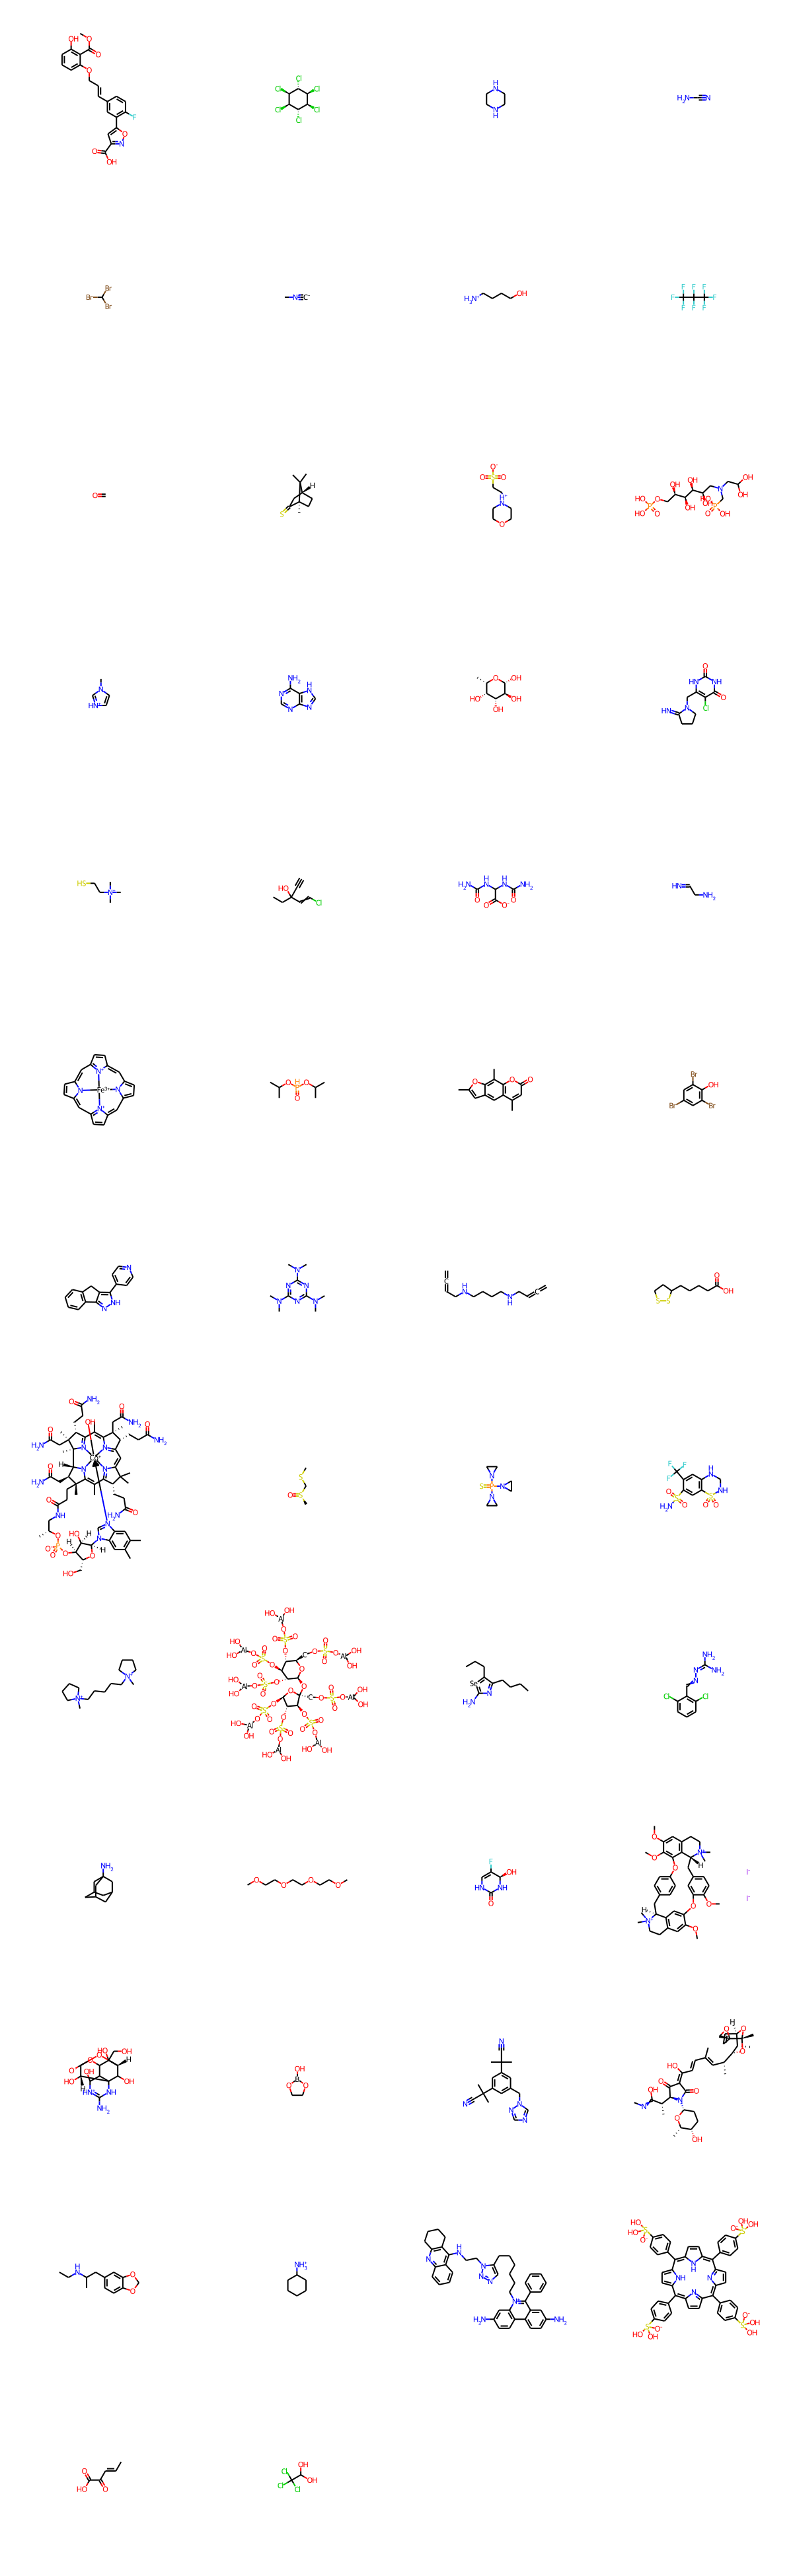

In [91]:
def distance_function(index1, index2):
    return 1 - DataStructs.TanimotoSimilarity(c_drugbank["fp"][index1], c_drugbank["fp"][index2])

picker = MaxMinPicker()
picked = list(picker.LazyPick(distance_function, len(mtor), 50))
Draw.MolsToGridImage([c_drugbank["mol"][mol] for mol in picked], subImgSize=(300, 300), molsPerRow=4)